In [3]:
pip install opencv-python

  Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-macosx_13_0_arm64.whl (37.3 MB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


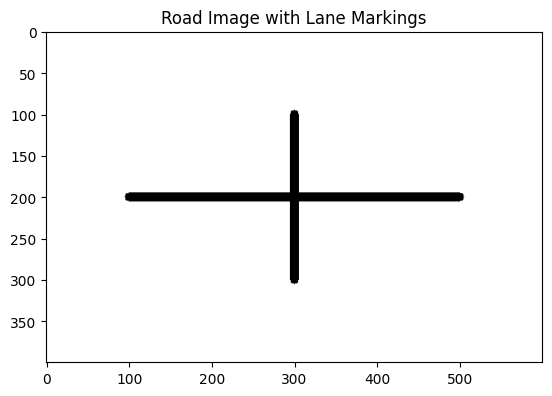

In [13]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Create a blank white image
image = np.ones((400, 600), dtype=np.uint8) * 255

# Draw lane markings
cv2.line(image, (100, 200), (500, 200), 0, 10)  # Horizontal line
cv2.line(image, (300, 100), (300, 300), 0, 10)  # Vertical line

# Save the image
cv2.imwrite('road.png', image)

# Display the image
plt.imshow(image, cmap='gray')
plt.title("Road Image with Lane Markings")
plt.show()

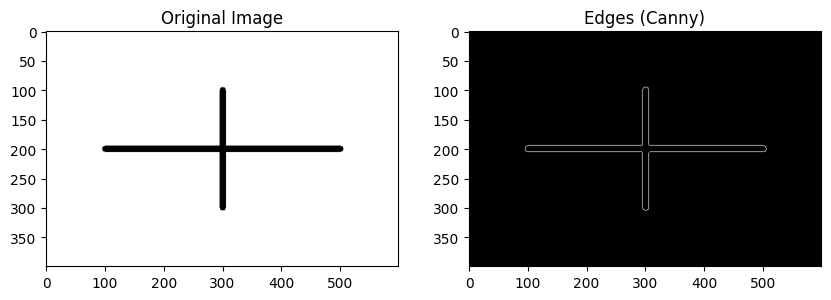

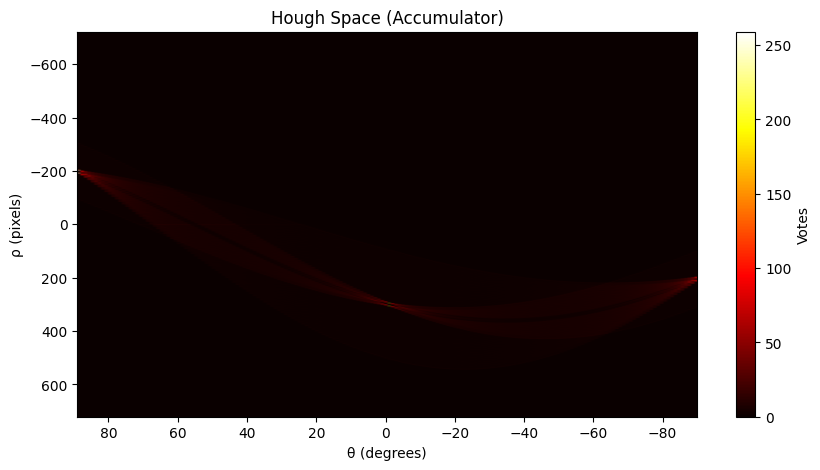

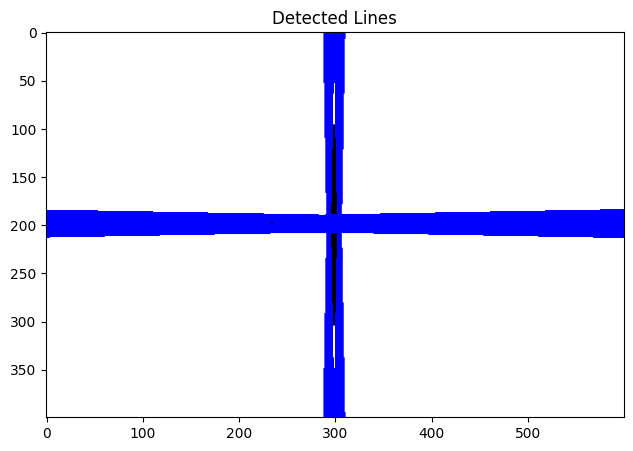

In [14]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load an image
image = cv2.imread('road.png', cv2.IMREAD_GRAYSCALE)  # Replace 'image.png' with your image file
edges = cv2.Canny(image, 50, 150, apertureSize=3)  # Detect edges using Canny edge detector

# Display the original image and edges
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(image, cmap='gray')

plt.subplot(1, 2, 2)
plt.title("Edges (Canny)")
plt.imshow(edges, cmap='gray')
plt.show()

# Hough Transform for Straight Lines
def hough_transform(edges):
    # Define the parameter space (ρ, θ)
    theta = np.deg2rad(np.arange(-90, 90))  # θ ranges from -90° to 90°
    width, height = edges.shape
    max_dist = int(np.ceil(np.sqrt(width**2 + height**2)))  # Maximum ρ value
    rho = np.arange(-max_dist, max_dist)  # ρ ranges from -max_dist to max_dist

    # Initialize the accumulator array
    accumulator = np.zeros((len(rho), len(theta)), dtype=np.uint64)

    # Get the indices of edge points
    y_idxs, x_idxs = np.nonzero(edges)

    # Voting in the accumulator array
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for theta_idx in range(len(theta)):
            t = theta[theta_idx]
            r = int(x * np.cos(t) + y * np.sin(t))  # Compute ρ
            rho_idx = np.argmin(np.abs(rho - r))  # Find the closest ρ index
            accumulator[rho_idx, theta_idx] += 1  # Increment the accumulator

    return accumulator, theta, rho

# Perform Hough Transform
accumulator, theta, rho = hough_transform(edges)

# Visualize the accumulator (Hough Space)
plt.figure(figsize=(10, 5))
plt.imshow(accumulator, cmap='hot', aspect='auto', 
           extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), rho[-1], rho[0]])
plt.title("Hough Space (Accumulator)")
plt.xlabel("θ (degrees)")
plt.ylabel("ρ (pixels)")
plt.colorbar(label="Votes")
plt.show()

# Detect lines by finding peaks in the accumulator
def detect_lines(accumulator, theta, rho, threshold):
    peaks = np.argwhere(accumulator > threshold)  # Find peaks above the threshold
    lines = []
    for peak in peaks:
        rho_idx, theta_idx = peak
        r = rho[rho_idx]
        t = theta[theta_idx]
        lines.append((r, t))
    return lines

# Detect lines
lines = detect_lines(accumulator, theta, rho, threshold = 0.2 * np.max(accumulator) ) # 20% of the maximum value)

# Draw detected lines on the original image
def draw_lines(image, lines):
    output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    for r, t in lines:
        a = np.cos(t)
        b = np.sin(t)
        x0 = a * r
        y0 = b * r
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(output, (x1, y1), (x2, y2), (0, 0, 255), 2)  # Draw the line in red
    return output

# Draw and display the detected lines
output_image = draw_lines(image, lines)
plt.figure(figsize=(10, 5))
plt.title("Detected Lines")
plt.imshow(output_image)
plt.show()

Edge Detection:

The Canny edge detector is used to extract edges from the input image. These edges are the input for the Hough Transform.

Hough Transform:

The parameter space 
(
ρ
,
θ
)
(ρ,θ) is defined, where:

ρ
ρ is the distance from the origin to the line.

θ
θ is the angle of the normal to the line.

An accumulator array is initialized to count votes for each 
(
ρ
,
θ
)
(ρ,θ) pair.

For each edge point 
(
x
,
y
)
(x,y), the corresponding 
(
ρ
,
θ
)
(ρ,θ) values are computed, and the accumulator is incremented.

Visualization:

The accumulator (Hough Space) is visualized as a heatmap, where brighter spots indicate higher votes for specific 
(
ρ
,
θ
)
(ρ,θ) pairs.

Line Detection:

Peaks in the accumulator (above a threshold) correspond to detected lines.

The detected lines are drawn on the original image.